In [1]:
import torch
import numpy as np
import random
import zarr
from skimage.segmentation import relabel_sequential
from scipy.ndimage import distance_transform_edt, map_coordinates
from matplotlib import gridspec, ticker
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
from dlmbl_unet import UNet
import torch.nn as nn
import torchvision.transforms.v2 as transforms_v2
from torch.utils.tensorboard import SummaryWriter
import subprocess
from tqdm import tqdm
from scipy.optimize import linear_sum_assignment
from torchvision import models

In [2]:
dict = {"tangles": 0, "Pick bodies": 1}

zarr_path = "/mnt/efs/aimbl_2025/student_data/S-DM/Data/zarr_storage/nft_pb_classification.zarr"
root = zarr.open (zarr_path)

print (dict["tangles"], )

len(root["tangles"])

0


2381

In [3]:
#Helper functions
def load_data (zarr_path):
    x_arrays = []
    y_array = []
    root = zarr.open (zarr_path)
    for conditions in list (root.keys()):
        images = root [conditions].keys()
        for i in range (len(root[conditions])):
            x = root[conditions][str (i)][:].astype ("float32")
            x = np.expand_dims (x, axis = 0)
            y = dict[conditions]
            x_arrays.append (x)
            y_array.append (y)
    x_array = np.concatenate (x_arrays)
    

    return x_array, y_array

def train(
    model,
    loader,
    optimizer,
    loss_function,
    epoch,
    log_interval=100,
    log_image_interval=20,
    tb_logger=None,
    device=None,
    early_stop=False,
):
    if device is None:
        # You can pass in a device or we will default to using
        # the gpu. Feel free to try training on the cpu to see
        # what sort of performance difference there is
        if torch.cuda.is_available():
            device = torch.device("cuda")
        else:
            device = torch.device("cpu")

    # set the model to train mode
    model.train()

    # move model to device
    model = model.to(device)

    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
 
        x, y = x.to(device), y.to(device)

        # zero the gradients for this iteration
        optimizer.zero_grad()

        # apply model and calculate loss
        prediction = model(x)
        # if y.dtype != prediction.dtype:
        #     y = y.type(prediction.dtype)
        loss = loss_function(prediction, y)

        # backpropagate the loss and adjust the parameters
        loss.backward()
        optimizer.step()

        # log to console
        if batch_id % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_id * len(x),
                    len(loader.dataset),
                    100.0 * batch_id / len(loader),
                    loss.item(),
                )
            )

        



        # log to tensorboard
        if tb_logger is not None:
            step = epoch * len(loader) + batch_id
            tb_logger.add_scalar(
                tag="train_loss", scalar_value=loss.item(), global_step=step
             )
            # # check if we log images in this iteration
            # if step % log_image_interval == 0:
            #     tb_logger.add_images(
            #         tag="input", img_tensor=x.to("cpu"), global_step=step
            #     )
            #     tb_logger.add_images(
            #         tag="target", img_tensor=y.to("cpu"), global_step=step
            #     )
            #     tb_logger.add_images(
            #         tag="prediction",
            #         img_tensor=prediction.to("cpu").detach(),
            #         global_step=step,
            #     )

        if early_stop and batch_id > 5:
            print("Stopping test early!")
            break

def launch_tensorboard(log_dir):
    import socket

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.bind(("", 0))
        port = s.getsockname()[1]

    tensorboard_cmd = f"tensorboard --logdir={log_dir} --port={port}"
    process = subprocess.Popen(tensorboard_cmd, shell=True)
    print(
        f"TensorBoard started at http://localhost:{port}. \n"
        "If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL."
    )
    return process

In [18]:
a = load_data (zarr_path)

a[0].dtype

dtype('float32')

In [23]:
print (a[0].shape)
print (len (a[1]))
print (a[1])

(4002, 128, 128)
4002
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [4]:
class ClassificationDataset(Dataset):
    def __init__(self, zarr_path, transform = None):
        
        
        self.zarr_path = zarr_path

        self.x, self.y = load_data(self.zarr_path)
        self.transform = transform
        self.transform = transform
        
       

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        img = self.x[idx]  
        label = self.y[idx] 

        img = torch.tensor(img).unsqueeze(0)
        label = torch.tensor(label, dtype = torch.long)
        
        
        if self.transform:
            seed = torch.seed()
            torch.manual_seed(seed)
            img = self.transform (img)
            
        
        

        

    

        return img, label

In [5]:
dataset = ClassificationDataset (zarr_path=zarr_path)

torch.Size([128, 128])
torch.int64


Text(0.5, 1.0, 'tangles')

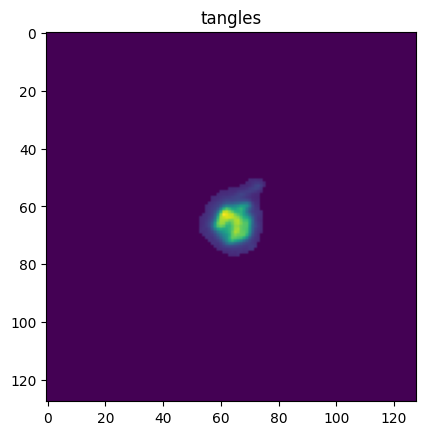

In [172]:
index = random.choice (range(0, len (dataset)))
img = dataset [index][0].squeeze(0)
print (img.shape)
label = dataset [index][1]
print (label.dtype)
# We use the <code style="color: black">plot_two</code> function (imported in the first cell) to verify that our
# dataset solution is correct. The output should show 2 images: the raw image and
# the corresponding SDT.
# plot_two(img, sdt,  label="SDT")
# sdt.shape
plt.imshow (img)
plt.title (next ((k for k, v in dict.items() if v == label), None))



In [173]:
lesion_classifier = models.resnet18(weights = None)
lesion_classifier.conv1 = torch.nn.Conv2d(1, 64, kernel_size=3)
lesion_classifier.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=2)
)


In [31]:
print (classifier)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [174]:
torch.manual_seed (41)

training, validation = random_split(dataset, lengths = (0.8, 0.2))
print (len(training))
learning_rate = 1e-4
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam (lesion_classifier.parameters(), lr = learning_rate)
train_dataloader = DataLoader (training, shuffle=True, batch_size=16)
val_dataloader = DataLoader (validation)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# logger = SummaryWriter("runs/classifier_test")

3202


In [ ]:
launch_tensorboard("runs/classifier_test")

for epoch in range(1000):
    train (model= lesion_classifier,
           loader = train_dataloader,
           
            optimizer = optimizer,
            loss_function = loss, epoch = epoch, device=device, tb_logger=logger)
    if epoch % 100 ==0:
        torch.save(
            {
            "unet": classifier.state_dict(),
            "epoch": epoch,
                # "losses": losses,
                },
                f"/mnt/efs/aimbl_2025/student_data/S-DM/Data/checkpoints_classifier/resnet_{epoch}.pth",)
print ("Training completed!")

TensorBoard started at http://localhost:34673. 
If you are using VSCode remote session, forward the port using the PORTS tab next to TERMINAL.
Train Epoch: 0 [0/3202 (0%)]	Loss: 0.001975


/home/S-DM/conda/envs/masketeers/lib/python3.11/site-packages/tensorboard/default.py:30: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:34673/ (Press CTRL+C to quit)


Train Epoch: 0 [1600/3202 (50%)]	Loss: 0.009889
Train Epoch: 0 [400/3202 (100%)]	Loss: 0.005373
Train Epoch: 1 [0/3202 (0%)]	Loss: 0.043547
Train Epoch: 1 [1600/3202 (50%)]	Loss: 0.099245
Train Epoch: 1 [400/3202 (100%)]	Loss: 0.097134
Train Epoch: 2 [0/3202 (0%)]	Loss: 0.026321
Train Epoch: 2 [1600/3202 (50%)]	Loss: 0.004078
Train Epoch: 2 [400/3202 (100%)]	Loss: 0.000811
Train Epoch: 3 [0/3202 (0%)]	Loss: 0.002884
Train Epoch: 3 [1600/3202 (50%)]	Loss: 0.000821
Train Epoch: 3 [400/3202 (100%)]	Loss: 0.000741
Train Epoch: 4 [0/3202 (0%)]	Loss: 0.258458
Train Epoch: 4 [1600/3202 (50%)]	Loss: 0.039827
Train Epoch: 4 [400/3202 (100%)]	Loss: 0.100679
Train Epoch: 5 [0/3202 (0%)]	Loss: 0.026674
Train Epoch: 5 [1600/3202 (50%)]	Loss: 0.247302
Train Epoch: 5 [400/3202 (100%)]	Loss: 0.003079
Train Epoch: 6 [0/3202 (0%)]	Loss: 0.016005
Train Epoch: 6 [1600/3202 (50%)]	Loss: 0.002526
Train Epoch: 6 [400/3202 (100%)]	Loss: 0.008920
Train Epoch: 7 [0/3202 (0%)]	Loss: 0.037515
Train Epoch: 7 [1600

In [175]:
checkpoint = torch.load ("/mnt/efs/aimbl_2025/student_data/S-DM/Data/checkpoints_classifier_CE/resnet_3000.pth")
lesion_classifier.load_state_dict (checkpoint['unet'])

<All keys matched successfully>

In [176]:
def predict(model, dataset):
    dataset_prediction = []
    dataset_groundtruth = []
    with torch.no_grad():
        for x, y_true in dataset:
            inp = x[None].to(device)
            y_pred = model(inp)
            dataset_prediction.append(y_pred.argmax().cpu().numpy())
            dataset_groundtruth.append(y_true)

    return np.array(dataset_prediction), np.array(dataset_groundtruth)


In [182]:
lesion_classifier.eval()
lesion_classifier.to (device)

prediction, true_labels = predict (lesion_classifier, validation)

In [181]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


# Plot confusion matrix
# originally from Runqi Yang;
# see https://gist.github.com/hitvoice/36cf44689065ca9b927431546381a3f7
def cm_analysis(y_true, y_pred, title, figsize=(10, 10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args:
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    labels = ["0", "1"]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = "%.1f%%\n%d/%d" % (p, c, s)
            elif c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%\n%d" % (p, c)
    cm = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(cm, annot=annot, fmt="", vmax=100)
    ax.set_title(title)

/tmp/ipykernel_16518/2189541121.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  annot[i, j] = "%.1f%%\n%d/%d" % (p, c, s)


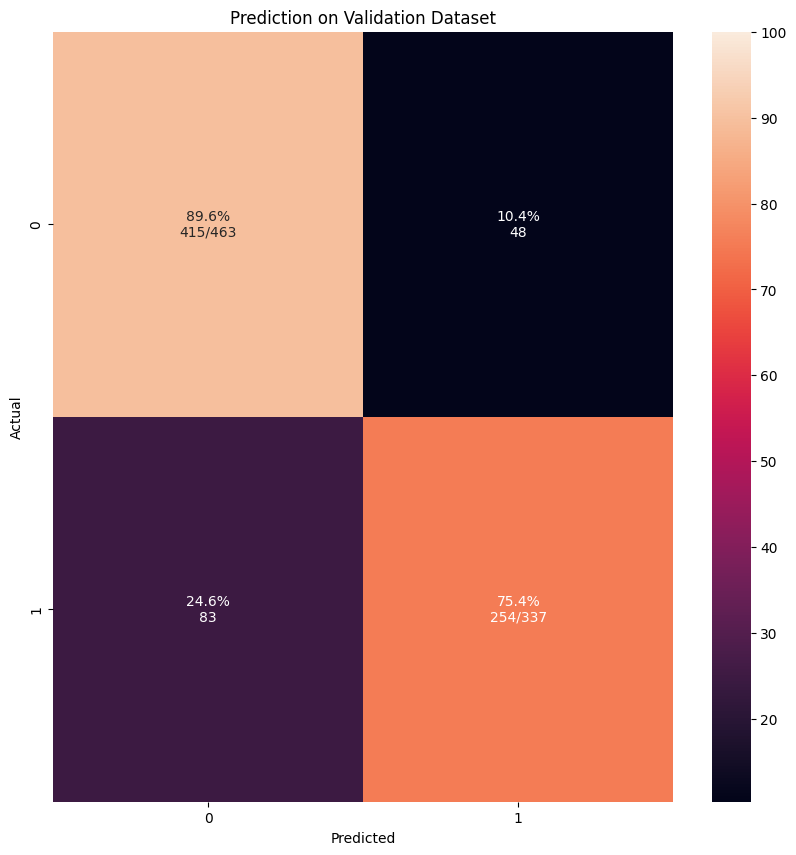

In [183]:
cm_analysis(true_labels, prediction, "Prediction on Validation Dataset")